In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = [cv2.imread('./images/andrew.jpeg'), cv2.imread('./images/bengio.jpeg'),
          cv2.imread('./images/goodfellow.jpeg'), cv2.imread('./images/leskovec.jpeg')]
note_image = cv2.imread('./note.png')

www = cv2.imread('./images/www.png')


In [4]:
def image_show(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)


def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [5]:
def conv2D(img, filters, stride, padding):

    f = filters[0].shape[0]
    p = 0 if padding == 'valid' else int((f - 1) / 2)

    def out_size(img):
        x = int((img.shape[0] + 2 * p - f) / stride + 1)
        y = int((img.shape[1] + 2 * p - f) / stride + 1)
        return (x, y)
    # finding output size images
    output_size = out_size(img)
    outputs = [np.zeros(output_size) for fi in filters]

    # add pading to image
    new_image_size = (img.shape[0] + 2 * p, img.shape[1] + 2 * p)
    if img.ndim == 3:
        image_padding = np.zeros((*new_image_size, img.shape[2]))
    else:
        image_padding = np.zeros(new_image_size)

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            image_padding[row + p, col + p] = img[row, col]
    img = image_padding

    # Convolution
    print(img.shape)
    for i, output in enumerate(outputs):
        for row in range(output_size[0]):
            for col in range(output_size[1]):
                output[row, col] = np.sum(
                    filters[i] * img[(row * stride):(row * stride) + f, (col * stride):(col * stride) + f])
        if img.ndim == 3:
            output = output / img.shape[2]

    return outputs


Now we need to check <b>conv2D</b> by some tests to make sure  it works without any problems: 

Finding edges example

(224, 224, 3)


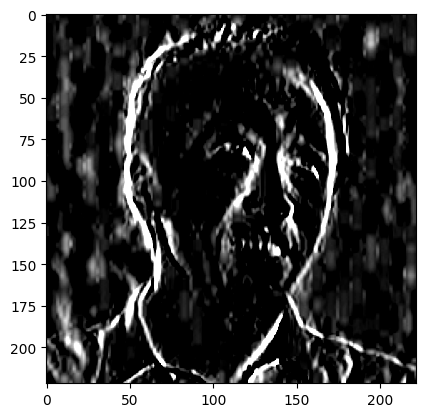

In [16]:
kernel = np.array([[[1, 1, 1], [0, 0, 0], [-1, -1, -1]], [[1, 1, 1],
                  [0, 0, 0], [-1, -1, -1]], [[1, 1, 1], [0, 0, 0], [-1, -1, -1]]])
filters = [kernel]
image_show(conv2D(images[0], filters=filters, stride=1, padding='valid')[0])


Smoothing(lowpass) filters example (stride=2)

(225, 225)


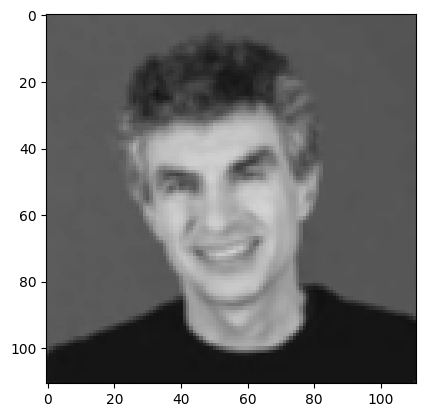

In [17]:
kernel = np.ones((5, 5)) / 25
filters = [kernel]
gray = to_gray(images[1])
image_show(conv2D(gray, filters=filters, stride=2, padding='valid')[0])


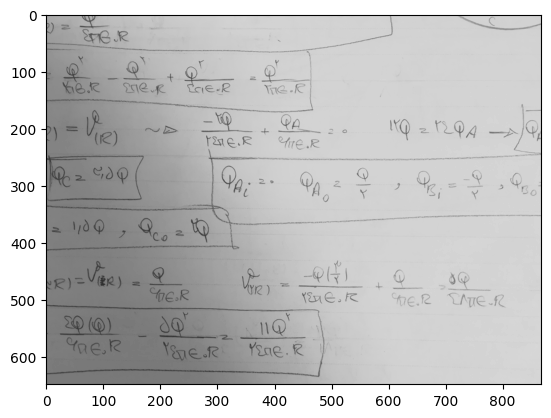

In [8]:
gray = to_gray(note_image)
image_show(gray)


implementation of <b><i>camscanner</i></b> using <b>Sharpening (highpass) filters</b>

(648, 868)
(887, 1034)


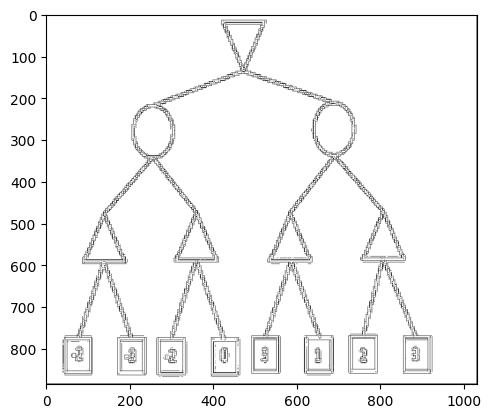

In [12]:
kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]]) * -1
filters = [kernel]
print(gray.shape)
new_image = conv2D(to_gray(www), filters, 1, padding='same')[0].astype(np.int16)
# print(new_image.ndim)
# sharped = 0.7 * new_image


def f(x):
    return 255 if x < 50 else 0


vf = np.vectorize(f)
sharped = vf(new_image)
image_show(sharped)


now we sure <b>conv2D</b> works well!</br>
time to use filters

In [20]:
horizontal_edge = np.array([[-1, -1, -1],
                            [0, 0, 0],
                            [1, 1, 1]])

vertical_edge = np.array([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]])

sharpening = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])

weighted_averaging_3x3 = (1/16)*np.array([[1, 2, 1],
                                          [2, 4, 2],
                                          [1, 2, 1]])

layer_one_kernekl = [horizontal_edge, vertical_edge,
                     sharpening, weighted_averaging_3x3]


In [21]:
robert_x = np.array([[1, 0],
                     [0, -1]])

robert_y = np.array([[0, +1],
                     [-1, 0]])

averaging_2x2 = (1/4)*np.array([[1, 1],
                                [1, 1]])

layer_two_kernekl = [robert_x, robert_y, averaging_2x2]


In [22]:
# mkae 3d (C=3) filters from 2d filters
l1_filters = []
for l in layer_one_kernekl:
    l1_filters.append(np.concatenate([l, l, l], axis=1).reshape((3, 3, 3), order='F'))


images_for_plotting = []
concated_features = []

for image in images:
    layer_one_output = conv2D(image, l1_filters, stride=1, padding='same')
    print(layer_one_output[0].ndim)
    list_image = [image]
    list_image.extend(layer_one_output)
    images_for_plotting.append(list_image)
    new_shape = (*list(layer_one_output[0].shape)[:2], 4)
    # we need to concatenate the 4 layers gor next step
    new_4d_image = np.concatenate(
        layer_one_output, axis=1).reshape(new_shape, order='F')
    concated_features.append(new_4d_image)


(226, 226, 3)
2
(227, 227, 3)
2
(222, 268, 3)
2
(202, 202, 3)
2


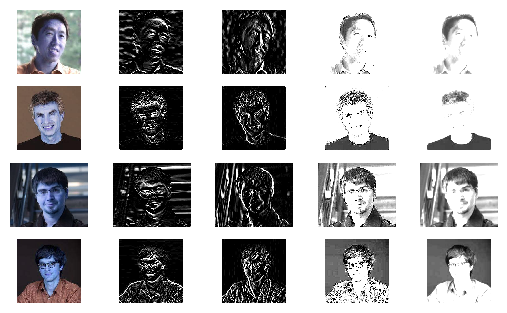

In [23]:
for i, image_set in enumerate(images_for_plotting):
    for j, image in enumerate(  ):
        plt.subplot(len(image_set), len(images_for_plotting) +
                    1, i * len(image_set) + j + 1)
        plt.imshow(image, cmap='gray', vmin=0,
                   vmax=255, interpolation='nearest')
        plt.axis('off')


plt.show()


In [24]:
l2_filters = []
for l in layer_two_kernekl:
    l2_filters.append(np.concatenate([l, l, l, l], axis=1).reshape((2, 2, 4), order='F'))


images_for_plotting = []
layer_two_outputs = []
for i , _4d_ in enumerate(concated_features):
    list_image = [images[i]]
    layer_two_output = conv2D(_4d_, l2_filters, stride=2, padding='valid')
    list_image.extend(layer_two_output)
    layer_two_outputs.append(layer_two_output)
    images_for_plotting.append(list_image)


(224, 224, 4)
(225, 225, 4)
(220, 266, 4)
(200, 200, 4)


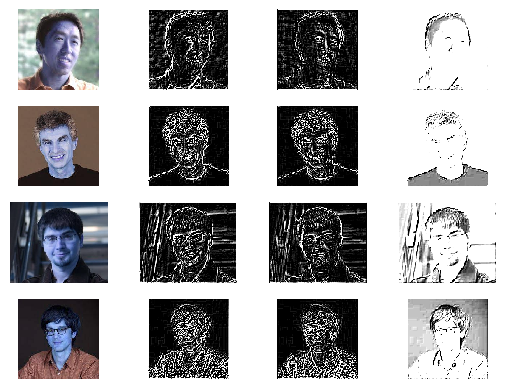

In [25]:
for i, image_set in enumerate(images_for_plotting):
    for j, image in enumerate(image_set):
        plt.subplot(len(images_for_plotting), len(
            image_set), i * len(image_set) + j + 1)
        plt.imshow(image, cmap='gray', vmin=0,
                   vmax=255, interpolation='nearest')
        plt.axis('off')


plt.show()
